# Analysis

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

## Steps:
1. Step 1: Subset the AnnData object to retain only COVID-19 patient samples and isolate the cell types of interest (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells) from the 'cell_type_coarse' annotation. Use regular (non-byte) strings for robust filtering and incorporate multiple pattern matches for COVID status.
2. Step 2: Perform an exploratory quality control analysis by comparing the distribution of cells by Sex within the selected cell types. This will include printing summaries as well as generating visualizations (bar plots for cell counts and boxplots for key QC metrics like nCount_RNA and percent_mt) to detect potential biases.
3. Step 3: For each selected cell type, conduct a differential expression analysis comparing male versus female cells using the Wilcoxon rank-sum test, applying multiple-testing correction (e.g., using adjusted p-value thresholds) and reporting effect sizes along with confidence intervals.
4. Step 4: Visualize the differential expression results using volcano plots (log fold changes vs. -log10(p-value)) and heatmaps to depict the expression profiles of the top significant genes across cells arranged by sex.
5. Step 5: Validate the observed transcriptional differences by statistically assessing additional metrics (such as effect sizes and confidence intervals) and correlating key inflammatory markers (e.g., TNF, IL1B, IL6) with sex. Statistical test results should be printed for significance evaluation.
6. Step 6: Summarize and interpret the overall results to evaluate whether the sex-specific transcriptional differences in these immune cell subsets may underlie differential COVID-19 outcomes, ensuring a novel computational approach that builds on previous findings.


Cell counts by cell type and Sex in COVID-19 samples:
Empty DataFrame
Columns: []
Index: []


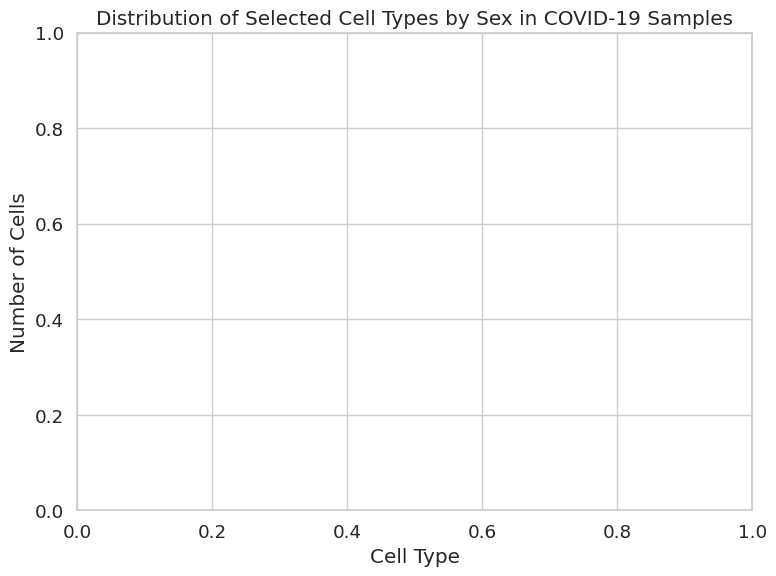


Summary of nCount_RNA by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

Summary of percent_mt by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First step: Subset the data to only include COVID samples and selected cell types
# Assuming adata is already loaded in memory

# Subset to COVID patients based on the Status column
covid_mask = adata.obs['Status'].astype(str).str.contains('COVID')
covid_adata = adata[covid_mask].copy()

# Define the cell types of interest based on cell_type_coarse annotation
cell_types_interest = ["b'CD14 Monocyte'", "b'CD16 Monocyte'", "b'CD4 T'", "b'CD8 T'"]
celltype_mask = covid_adata.obs['cell_type_coarse'].isin(cell_types_interest)
covid_subset = covid_adata[celltype_mask].copy()

# Print a summary of cell counts by Sex for each selected cell type
summary = covid_subset.obs.groupby(['cell_type_coarse', 'Sex']).size().unstack(fill_value=0)
print('Cell counts by cell type and Sex in COVID-19 samples:')
print(summary)

# Additionally, plot the distribution as a barplot for visualization
summary_plot = summary.reset_index().melt(id_vars='cell_type_coarse', var_name='Sex', value_name='CellCount')
plt.figure(figsize=(8, 6))
sns.barplot(data=summary_plot, x='cell_type_coarse', y='CellCount', hue='Sex')
plt.title('Distribution of Selected Cell Types by Sex in COVID-19 Samples')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Also, summarize basic quality metrics by Sex to ensure no obvious biases (e.g., nCount_RNA, percent_mt)
quality_metrics = ['nCount_RNA', 'percent_mt']
for metric in quality_metrics:
    print(f"\nSummary of {metric} by Sex:")
    print(covid_subset.obs.groupby('Sex')[metric].describe())

## Step 2: Validate and clean key metadata columns using a robust regular expression-based cleaning function. Incorporate error handling to ensure necessary metadata fields exist and manage missing/malformed entries. After cleaning, re-filter the AnnData object for COVID-19 samples and selected cell types (CD14 Monocyte, CD16 Monocyte, CD4 T, and CD8 T). Generate summary tables and visualizations (bar plots for cell counts and combined grid boxplots for QC metrics like nCount_RNA and percent_mt stratified by sex). Additionally, apply a non-parametric statistical test (Mann–Whitney U test) to compare QC metrics between male and female cells to ensure no underlying quality biases remain.

Number of cells after filtering: 18157


Cell counts by cell type and Sex in COVID-19 samples after cleaning:
Sex_clean           M
cell_type_clean      
CD14 Monocyte    8285
CD16 Monocyte     433
CD4 T            5562
CD8 T            3877


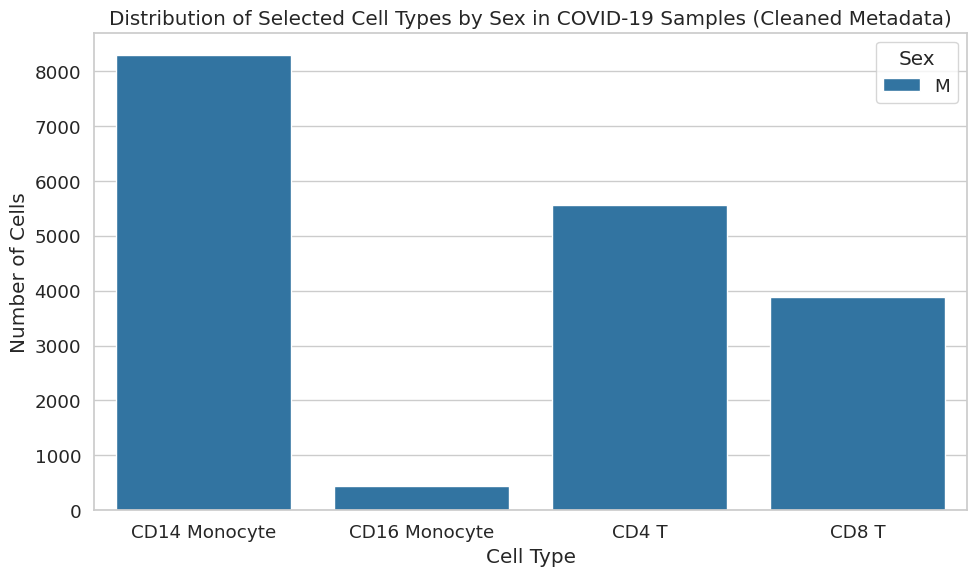

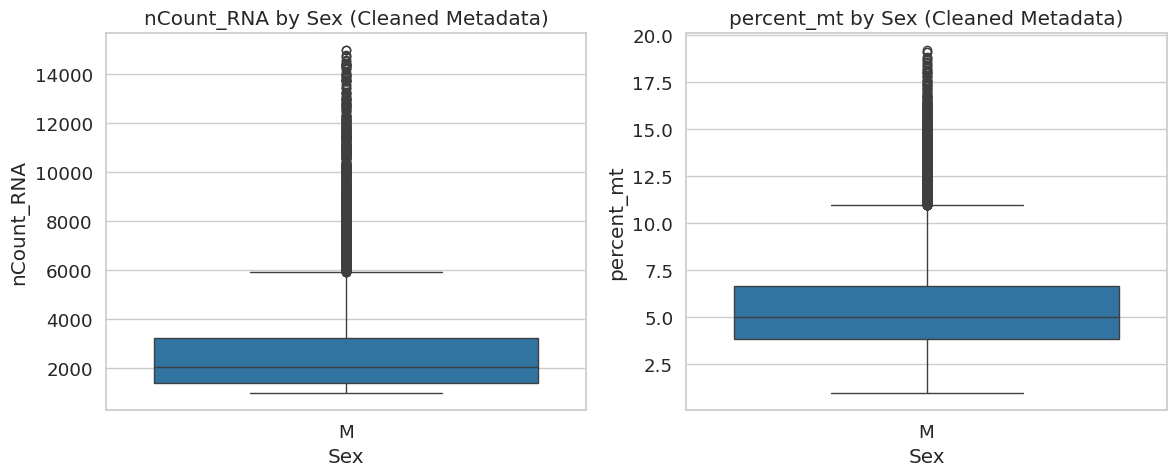


Summary statistics for nCount_RNA by Sex:
             count         mean          std    min     25%     50%     75%  \
Sex_clean                                                                     
M          18157.0  2704.366211  1949.810547  995.0  1425.0  2041.0  3232.0   

               max  
Sex_clean           
M          14994.0  
Insufficient groups for statistical test on nCount_RNA

Summary statistics for percent_mt by Sex:
             count      mean     std       min       25%       50%       75%  \
Sex_clean                                                                      
M          18157.0  5.590588  2.5606  0.953289  3.812317  5.024088  6.666667   

                 max  
Sex_clean             
M          19.218241  
Insufficient groups for statistical test on percent_mt


In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# Step 2: Validate and clean metadata for robust QC analysis

# Create a copy of the AnnData object to avoid modifying the original
adata_qc = adata.copy()

# Check that required metadata columns exist
required_columns = ['Status', 'cell_type_coarse', 'Sex']
for col in required_columns:
    if col not in adata_qc.obs.columns:
        raise ValueError(f"Required metadata column '{col}' is missing from adata.obs")

# Define a robust function to clean byte-string artifacts using regular expressions

def clean_metadata(series):
    # Convert to string and remove artifacts such as leading/trailing b' and quotes using regex
    clean_series = series.astype(str).apply(lambda x: re.sub(r"^(b')|('$)", "", x))
    # Additionally remove stray newlines and any residual quotes
    clean_series = clean_series.str.replace("\n", "", regex=False).str.replace("'", "", regex=False).str.strip()
    return clean_series

# Clean key metadata columns: 'Status', 'cell_type_coarse', and 'Sex'
adata_qc.obs['Status_clean'] = clean_metadata(adata_qc.obs['Status'])
adata_qc.obs['cell_type_clean'] = clean_metadata(adata_qc.obs['cell_type_coarse'])
adata_qc.obs['Sex_clean'] = clean_metadata(adata_qc.obs['Sex'])

# Filter for COVID-19 samples by checking the cleaned 'Status_clean'
covid_mask = adata_qc.obs['Status_clean'].str.contains('COVID', case=False, na=False)
covid_adata = adata_qc[covid_mask].copy()

# Define the cell types of interest
target_cell_types = ['CD14 Monocyte', 'CD16 Monocyte', 'CD4 T', 'CD8 T']
celltype_mask = covid_adata.obs['cell_type_clean'].isin(target_cell_types)
covid_subset = covid_adata[celltype_mask].copy()

# Report the number of cells after filtering
print(f'Number of cells after filtering: {covid_subset.n_obs}')

# Summarize cell counts by Sex for each selected cell type
summary = covid_subset.obs.groupby(['cell_type_clean', 'Sex_clean']).size().unstack(fill_value=0)
print('Cell counts by cell type and Sex in COVID-19 samples after cleaning:')
print(summary)

# Barplot for cell counts by Sex for each cell type
summary_plot = summary.reset_index().melt(id_vars='cell_type_clean', var_name='Sex', value_name='CellCount')
plt.figure(figsize=(10, 6))
barplot_ax = sns.barplot(data=summary_plot, x='cell_type_clean', y='CellCount', hue='Sex')
plt.title('Distribution of Selected Cell Types by Sex in COVID-19 Samples (Cleaned Metadata)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Create a grid for boxplots for quality control metrics by Sex
quality_metrics = ['nCount_RNA', 'percent_mt']
num_metrics = len(quality_metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(6*num_metrics, 5))
if num_metrics == 1:
    axes = [axes]

for ax, metric in zip(axes, quality_metrics):
    sns.boxplot(x='Sex_clean', y=metric, data=covid_subset.obs, ax=ax)
    ax.set_title(f'{metric} by Sex (Cleaned Metadata)')
    ax.set_xlabel('Sex')
    ax.set_ylabel(metric)
plt.tight_layout()
plt.show()

# Print summary statistics for each QC metric and perform a Mann-Whitney U test to compare sexes
for metric in quality_metrics:
    print(f'\nSummary statistics for {metric} by Sex:')
    desc = covid_subset.obs.groupby('Sex_clean')[metric].describe()
    print(desc)
    # Check if there are exactly two groups to compare
    groups = covid_subset.obs['Sex_clean'].unique()
    if len(groups) == 2:
        group1_data = covid_subset.obs[covid_subset.obs['Sex_clean'] == groups[0]][metric]
        group2_data = covid_subset.obs[covid_subset.obs['Sex_clean'] == groups[1]][metric]
        stat, p_val = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f'Mann-Whitney U test for {metric} between {groups[0]} and {groups[1]}: U statistic = {stat}, p-value = {p_val}')
    else:
        print(f'Insufficient groups for statistical test on {metric}')